In [1]:
from collections import defaultdict
import pandas as pd
import nltk
import numpy as np

import util


In [2]:
data_config = util.get_data_config()

In [3]:
nltk.download(['punkt', 'averaged_perceptron_tagger'])
# Optional
nltk.download(['brown', 'conll2000',])

[nltk_data] Downloading package punkt to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

# Load Data

In [4]:
summaries = pd.read_parquet(data_config['summaries_file_name'])
summaries.shape

(51, 2)

In [5]:
summaries.head()

,nct_id,brief_summary
0,NCT00037648,The purpose of this study is to determine the ...
1,NCT00048542,"This is a multicenter, Phase 3 randomized, pla..."
2,NCT00071487,The purpose of this study is to evaluate the s...
3,NCT00071812,The purpose of this study is to evaluate the s...
4,NCT00072839,The purpose of the study is to determine wheth...


In [6]:
synonyms_df = pd.read_parquet(data_config['processed_synonyms_file_name'])
synonyms_df.head()

,preferred_name,synonyms
id,,
4.0,levobupivacaine,"[chirocain, levobupivacaine, levobupivacaine H..."
5.0,(S)-nicardipine,"[(-)-Nicardipine, (-)-nicardipine, (S)-nicardi..."
6.0,(S)-nitrendipine,"[(-)-Nitrendipine, (-)-nitrendipine, (S)-nitre..."
13.0,levdobutamine,"[LY206243, levdobutamine, levdobutamine lactob..."
21.0,aminopterin,"[4-aminofolic acid, Aminofolic acid, 4-, amino..."


In [7]:
synonyms_df

,preferred_name,synonyms
id,,
4.0,levobupivacaine,"[chirocain, levobupivacaine, levobupivacaine H..."
5.0,(S)-nicardipine,"[(-)-Nicardipine, (-)-nicardipine, (S)-nicardi..."
6.0,(S)-nitrendipine,"[(-)-Nitrendipine, (-)-nitrendipine, (S)-nitre..."
13.0,levdobutamine,"[LY206243, levdobutamine, levdobutamine lactob..."
21.0,aminopterin,"[4-aminofolic acid, Aminofolic acid, 4-, amino..."
...,...,...
5739.0,avacincaptad pegol,"[ARC1905, arc1905, avacincaptad pegol, avacinc..."
5740.0,pozelimab,"[REGN3918, pozelimab, pozelimab-bbfg, regn3918..."
5741.0,elranatamab,"[PF-06863135, RN613, elranatamab, elranatamab-..."


In [8]:
word_set = set(
    word
    for synonyms in synonyms_df['synonyms']
    for synonym in synonyms
    for word in synonym.split()
)
print(f'vocabulary size: {len(word_set)}')
characters = set([char for word in word_set for char in word])
extra_characters = [char for char in characters if not char.isalpha()]
print(f'extra characters{sorted(extra_characters)}')

vocabulary size: 22449
extra characters['&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '>', '[', ']', '–']


In [9]:
# tagged_synonyms = []
# max_synonym_tokens = 0
# for synonyms in synonyms_df['synonyms']:
#     tags = []
#     for synonym in synonyms:
#         tokens = nltk.word_tokenize(synonym)
#         max_synonym_tokens = max(len(tokens), max_synonym_tokens)
#         for token in tokens[:-1]:
#             tags.append((token, f'C{len(tokens)}S'))
            
#         for token in tokens[-1:]:
#             tags.append((token, f'C{len(tokens)}E'))
#     tagged_synonyms.append(tags)
# max_synonym_tokens

In [10]:
all_tokens = []
all_synonyms = []
dataset_by_ngram = defaultdict(list)
for synonyms in synonyms_df['synonyms']:
    for synonym in synonyms:
        tokens = nltk.word_tokenize(synonym)
        all_tokens.append(tokens)
        all_synonyms.append(synonym)
        tags = []
        for token in tokens[:-1]:
            # tags.append((token, f'C-{len(tokens)}-S'))
            tags.append((token, f'C{len(tokens)}S'))
            
        for token in tokens[-1:]:
            # tags.append((token, f'C-{len(tokens)}-E'))
            tags.append((token, f'C{len(tokens)}E'))
        
        assert len(tags) == len(tokens)
        dataset_by_ngram[len(tags)].append(tags)

syn_counts_df = pd.DataFrame({
    'synonym': all_synonyms,
    'tokens': all_tokens,
})
syn_counts_df['token_count'] = syn_counts_df['tokens'].map(len)
syn_counts_df.head(10)

,synonym,tokens,token_count
0,chirocain,[chirocain],1
1,levobupivacaine,[levobupivacaine],1
2,levobupivacaine HCl,"[levobupivacaine, HCl]",2
3,levobupivacaine hcl,"[levobupivacaine, hcl]",2
4,levobupivacaine hydrochloride,"[levobupivacaine, hydrochloride]",2
5,(-)-Nicardipine,"[(, -, ), -Nicardipine]",4
6,(-)-nicardipine,"[(, -, ), -nicardipine]",4
7,(S)-nicardipine,"[(, S, ), -nicardipine]",4
8,(s)-nicardipine,"[(, s, ), -nicardipine]",4
9,(-)-Nitrendipine,"[(, -, ), -Nitrendipine]",4


# NgramTagger that uses N-1 tokens (instead of N-1 tags). 

In [11]:
def parse(text, parser, tagger):
    tagged = tagger.tag(nltk.word_tokenize(text))
    tree = parser.parse(tagged)
    return tree

def extract_grouped_terms(tree: nltk.Tree, group_tag: str = 'GROUP') -> list[str]:
    terms = []
    for subtree in tree:
        if type(subtree) != nltk.Tree:
            continue
        if subtree.label() != group_tag:
            continue
        term = ''.join([leaf[0] for leaf in subtree.leaves()])
        terms.append(term)
    return terms

class WordNgramTagger(nltk.NgramTagger):
    """
    My override of the NLTK NgramTagger class that considers previous
    tokens rather than previous tags for context.
    """
    def __init__(self, n, train=None, model=None,
                 backoff=None, cutoff=0, verbose=False):
        nltk.NgramTagger.__init__(self, n, train, model, backoff, cutoff, verbose)

    def context(self, tokens, index, history):
        tag_context = tuple(tokens[max(0,index-self._n+1):index])
        return tag_context, tokens[index]
    

In [12]:
taggers = [nltk.DefaultTagger('O')]
for n in sorted(dataset_by_ngram.keys()):
    print(n)
    train = dataset_by_ngram[n]
    # ngram_tagger = nltk.NgramTagger(n=n, train=train, backoff=taggers[-1])
    ngram_tagger = WordNgramTagger(n=n, train=train, backoff=taggers[-1])
    taggers.append(ngram_tagger)

tagger = taggers[-1]

1
2
3
4
5
6
7
8
9
14
19


In [13]:
grammar = '''GROUP: {<C1E>}'''
for num_tokens in dataset_by_ngram.keys():
    grammar += '\n{<C\dS>{' + str(num_tokens-1) + '}<C' + str(num_tokens) + 'E>}'
print(grammar)
regexp_parser = nltk.RegexpParser(grammar)

GROUP: {<C1E>}
{<C\dS>{0}<C1E>}
{<C\dS>{1}<C2E>}
{<C\dS>{3}<C4E>}
{<C\dS>{2}<C3E>}
{<C\dS>{4}<C5E>}
{<C\dS>{13}<C14E>}
{<C\dS>{5}<C6E>}
{<C\dS>{7}<C8E>}
{<C\dS>{6}<C7E>}
{<C\dS>{8}<C9E>}
{<C\dS>{18}<C19E>}


In [14]:
all_terms = [
    synonym
    for synonyms in synonyms_df['synonyms']
    for synonym in synonyms
]
all_trees = [
    parse(term, parser=regexp_parser, tagger=tagger)
    for term in all_terms
]
extracted = [
    extract_grouped_terms(tree) for tree in all_trees
]

df = pd.DataFrame({
    'term': all_terms,
    'tree': all_trees,
    'extracted': extracted
})

In [15]:
df['extracted_count'] = df['extracted'].map(len)
df['extracted_count'].value_counts()

extracted_count
1    24791
0     2624
Name: count, dtype: int64

In [16]:
df.head(10)

,term,tree,extracted,extracted_count
0,chirocain,"[[(chirocain, C1E)]]",[chirocain],1
1,levobupivacaine,"[(levobupivacaine, C2S)]",[],0
2,levobupivacaine HCl,"[[(levobupivacaine, C2S), (HCl, C2E)]]",[levobupivacaineHCl],1
3,levobupivacaine hcl,"[[(levobupivacaine, C2S), (hcl, C2E)]]",[levobupivacainehcl],1
4,levobupivacaine hydrochloride,"[[(levobupivacaine, C2S), (hydrochloride, C2E)]]",[levobupivacainehydrochloride],1
5,(-)-Nicardipine,"[[((, C9S), (-, C9S), (), C9S), (-Nicardipine,...",[(-)-Nicardipine],1
6,(-)-nicardipine,"[[((, C9S), (-, C9S), (), C9S), (-nicardipine,...",[(-)-nicardipine],1
7,(S)-nicardipine,"[[((, C9S), (S, C8S), (), C8S), (-nicardipine,...",[(S)-nicardipine],1
8,(s)-nicardipine,"[[((, C9S), (s, C8S), (), C8S), (-nicardipine,...",[(s)-nicardipine],1
9,(-)-Nitrendipine,"[[((, C9S), (-, C9S), (), C9S), (-Nitrendipine...",[(-)-Nitrendipine],1


In [17]:
def is_correct(term: str, extracted: list[str]) -> bool:
    if not extracted:
        return False
    return term.replace(' ', '') == extracted[0]
df['correct'] = df.apply(lambda row: is_correct(row['term'], row['extracted']), axis=1)
print(f'Accuracy: {df.correct.mean():.2%}')

Accuracy: 90.43%


In [18]:
df['term_token_count'] = df['term'].map(lambda term: len(nltk.word_tokenize(term)))

In [19]:
df[df['extracted_count']==0].term_token_count.value_counts()

term_token_count
1     2216
2      372
3       28
4        4
14       2
19       2
Name: count, dtype: int64

In [20]:
_df = df[df['extracted_count']==0].copy()
_df

,term,tree,extracted,extracted_count,correct,term_token_count
1,levobupivacaine,"[(levobupivacaine, C2S)]",[],0,False,1
14,levdobutamine,"[(levdobutamine, C2S)]",[],0,False,1
20,aminopterin,"[(aminopterin, C2S)]",[],0,False,1
56,5-fluorouracil,"[(5-fluorouracil, C2S)]",[],0,False,1
89,abacavir,"[(abacavir, C2S)]",[],0,False,1
...,...,...,...,...,...,...
27319,ensitrelvir,"[(ensitrelvir, C3S)]",[],0,False,1
27327,ritlecitinib,"[(ritlecitinib, C2S)]",[],0,False,1
27347,durlobactam,"[(durlobactam, C2S)]",[],0,False,1
27358,tofersen,"[(tofersen, C2S)]",[],0,False,1


In [21]:
_df[_df['term_token_count']==2]

,term,tree,extracted,extracted_count,correct,term_token_count
159,acefylline piperazine,"[(acefylline, C3S), (piperazine, C3S)]",[],0,False,2
297,acetopromazine maleate,"[(acetopromazine, C3S), (maleate, C3S)]",[],0,False,2
379,adenosine triphosphate,"[(adenosine, C4S), (triphosphate, C4S)]",[],0,False,2
494,alendronate sodium,"[(alendronate, C4S), (sodium, C3S)]",[],0,False,2
640,alverine citrate,"[(alverine, C3S), (citrate, C3S)]",[],0,False,2
...,...,...,...,...,...,...
26349,efgartigimod alfa,"[(efgartigimod, C6S), (alfa, C6S)]",[],0,False,2
26660,iron dextran,"[(iron, C4S), (dextran, C3S)]",[],0,False,2
26670,laidlomycin propionate,"[(laidlomycin, C3S), (propionate, C3S)]",[],0,False,2
26845,sodium sulfachloropyrazine,"[(sodium, C8S), (sulfachloropyrazine, C3S)]",[],0,False,2


# Classifier based chunker

In [22]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "prevpos": prevpos}

class ConsecutiveNPChunkTagger(nltk.TaggerI): # [_consec-chunk-tagger]

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) # [_consec-use-fe]
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): # [_consec-chunker]
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)


def create_group_tree(nodes: list[tuple[str, str]]) ->nltk.Tree:
    return nltk.Tree(
        'NP',
        nodes
    )


def get_filler_trees(words: list[str], size=3, tag='O') -> list[nltk.Tree]:
    trees = []
    selection = np.random.choice(words, size).tolist()
    for word in selection:
        # trees.append(nltk.Tree(word, [tag]))
        trees.append((word, tag))
    return trees


In [23]:
filler_words = (
    'The purpose of this study is to evaluate the safety and efficacy of 3 different doses of '
    'administered in addition to standard therapy, in patients with active SLE disease.'
).lower().split()

    
train_tree_synonyms = []
for synonyms in synonyms_df['synonyms']:
    trees = []
    for synonym in synonyms:
        tokens = nltk.word_tokenize(synonym)
        synonym_tags = []
        for token in tokens[:-1]:
            synonym_tags.append((token, f'C{len(tokens)}S'))
            
        for token in tokens[-1:]:
            synonym_tags.append((token, f'C{len(tokens)}E'))
            
        tree = create_group_tree(synonym_tags)
        trees.append(tree)
        
        trees.extend(get_filler_trees(filler_words))
    
    
    train_tree_synonyms.append(nltk.Tree('S', trees))
        

In [24]:
# Check that tree height is at most 3.
for index, tree in enumerate(train_tree_synonyms):
    if tree.height()>3:
        print('found')
        break

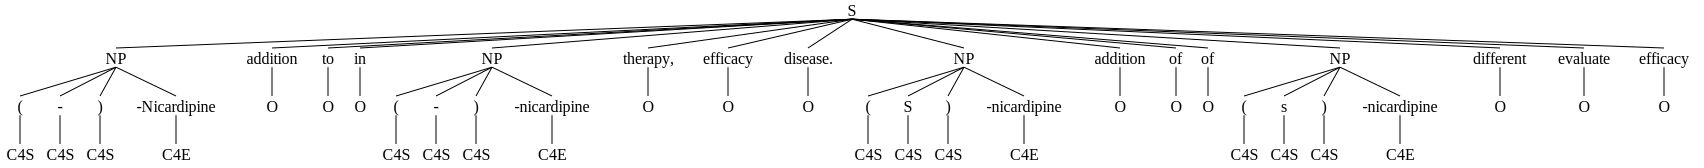

In [25]:
train_tree_synonyms[1]

In [26]:
train_tree_synonyms[1].height()

3

In [27]:
syn_counts_df['token_count'].value_counts()

token_count
1     17756
2      7535
3       980
4       765
5       245
6        93
8        15
7        14
9         8
14        2
19        2
Name: count, dtype: int64

## Prepare Ground Truth

In [28]:
ground_truth = {
    'NCT00037648': ['anakinra'],
    'NCT00048542': ['adalimumab', 'methotrexate'],
    'NCT00071487': ['belimumab'],
    'NCT00071812': ['belimumab'],
    'NCT00072839': ['ALX-0600'],
    'NCT00074438': ['rituximab', 'methotrexate'],
    'NCT00078806': ['etanercept'],
    'NCT00078819': ['etanercept'],
    'NCT00079937': ['omalizumab'],
    'NCT00090142': [],
    'NCT00092131': [],
    'NCT00095173': ['BMS-188667', 'Abatacept'],
    'NCT00097370': ['mepolizumab', 'mepolizumab'],
    'NCT00106522': ['tocilizumab', 'methotrexate', 'tocilizumab', 'tocilizumab', 'methotrexate'],
    'NCT00106535': ['tocilizumab', 'methotrexate', 'tocilizumab', 'tocilizumab'],
    'NCT00106548': ['tocilizumab', 'methotrexate', 'tocilizumab', 'tocilizumab'],
    'NCT00109408': ['tocilizumab', 'methotrexate', 'tocilizumab', 'methotrexate'],
    'NCT00109707': ['Imatinib', 'imatinib', 'imatinib', 'imatinib', 'Imatinib', 'imatinib','imatinib','imatinib'],
    'NCT00110916': ['anakinra', 'anakinra'],
    'NCT00111436': ['etanercept', 'etanercept', 'etanercept'],
    'NCT00119678': ['Abatacept', 'prednisone'],
    'NCT00120523': ['pimecrolimus'],
    'NCT00130390': ['nitazoxanide'],
    'NCT00137969': ['rituximab'],
    'NCT00141921': ['etanercept'],
    'NCT00146640': ['prednisone', 'prednisone'],
    'NCT00171860': ['imatinib mesylate', 'imatinib mesylate', 'prednisone', 'hydroxyurea', 'oxyurea'],
    'NCT00175877': ['Certolizumab Pegol'],
    'NCT00195663': ['adalimumab', 'methotrexate', 'adalimumab'],
    'NCT00195702': ['adalimumab', 'adalimumab', 'methotrexate',],
    'NCT00206596': ['Leukine'],
    'NCT00206661': ['sargramostim'],
    'NCT00206700': ['sargramostim'],
    'NCT00206713': ['Leukine', 'Leukine'],
    'NCT00207714': ['Golimumab', 'CNTO 148'],
    'NCT00207740': ['CNTO 148', 'golimumab'],
    'NCT00221026': [],
    'NCT00235820': ['Adalimumab', 'Methotrexate'],
    'NCT00244842': ['voclosporin'],
    'NCT00245570': [],
    'NCT00245765': ['CDP870'],
    'NCT00254293': ['Abatacept'],
    'NCT00264537': ['golimumab', 'methotrexate'],
    'NCT00264550': ['golimumab', 'methotrexate', 'methotrexate'],
    'NCT00265096': ['golimumab'],
    'NCT00265122': ['CNTO 1275'],
    'NCT00266565': [],
    'NCT00267956': ['CNTO 1275', 'ustekinumab'],
    'NCT00267969': ['ustekinumab', 'CNTO 1275'],
    'NCT00269841': [],
    'NCT00269854': [],
}
ground_truth = {k:list(set(v)) for k,v in ground_truth.items()}

In [29]:
preferred_name_by_term = {}
for _, row in synonyms_df.iterrows():
    preferred_name = row['preferred_name']
    synonyms = row['synonyms']
    for synonym in synonyms:
        # preferred_name_by_term[synonym.replace(' ', '')] = preferred_name
        preferred_name_by_term[synonym.replace(' ', '').lower()] = preferred_name

In [30]:
ground_truth_cleaned = {}
for nct_id, terms in ground_truth.items():
    terms_cleaned = []
    for term in terms:
        cleaned = term.replace(' ', '').lower()
        if cleaned not in preferred_name_by_term:
            continue
        terms_cleaned.append(preferred_name_by_term[cleaned])
    ground_truth_cleaned[nct_id] = list(set(terms_cleaned))

In [31]:
def split_summary_by_keywords(brief_summary: str, keywords: list[str]) -> str:
    tokens = [brief_summary]
    for keyword in keywords:
        new_tokens = []
        for token in tokens:
            split_tokens = token.split(keyword)
            for index, split_token in enumerate(split_tokens):
                new_tokens.append(split_token)
                if index < len(split_tokens) - 1:
                    new_tokens.append(keyword)
        tokens = new_tokens
    return tokens

def get_synonym_subtree(synonym):
    tokens = nltk.word_tokenize(synonym)
    synonym_tags = []
    for token in tokens[:-1]:
        synonym_tags.append((token, f'C{len(tokens)}S'))
        
    for token in tokens[-1:]:
        synonym_tags.append((token, f'C{len(tokens)}E'))
        
    tree = create_group_tree(synonym_tags)
    return tree

def get_gt_tree(brief_summary: str, keywords: list[str]) -> nltk.Tree:
    tokens = split_summary_by_keywords(brief_summary, keywords)
    for part in tokens:
        if part in keywords:
            tree.append(get_synonym_subtree(token))
        else:
            tree.extend([(t, 'O') for t in nltk.word_tokenize(part)])
    return nltk.Tree('S', tree)

In [32]:
# tagger = taggers[-1]
# test_trees = []
# for _, row in summaries.iterrows():
#     nct_id = row['nct_id']
#     keywords = ground_truth[nct_id]
#     brief_summary = row['brief_summary']
#     tree = get_gt_tree(brief_summary, keywords)
#     assert ''.join(split_summary_by_keywords(brief_summary, keywords)) == brief_summary
#     test_trees.append(tree)

In [33]:
# test_trees[1].height()

In [34]:
chunker = ConsecutiveNPChunker(train_tree_synonyms)

In [35]:
# Training set evaluation metric for the Chunker.
print(chunker.evaluate(train_tree_synonyms))

/tmp/ipykernel_270503/684302040.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print(chunker.evaluate(train_tree_synonyms))


ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


## Test set evaluation metric for the Chunker.

In [36]:
tagger = taggers[-1]
test_trees = []
for _, row in summaries.iterrows():
    nct_id = row['nct_id']
    keywords = ground_truth[nct_id]
    brief_summary = row['brief_summary']
    # _tags = tagger.tag(nltk.word_tokenize(brief_summary))
    _tags = tagger.tag(nltk.word_tokenize(brief_summary.lower()))
    tree = chunker.parse(_tags)
    test_trees.append(tree)

In [37]:
max([t.height() for t in train_tree_synonyms])

3

In [38]:
# Note: 100% is too good, the dataset is rather small.
print(chunker.evaluate(test_trees))

ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


/tmp/ipykernel_270503/2866446362.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print(chunker.evaluate(test_trees))


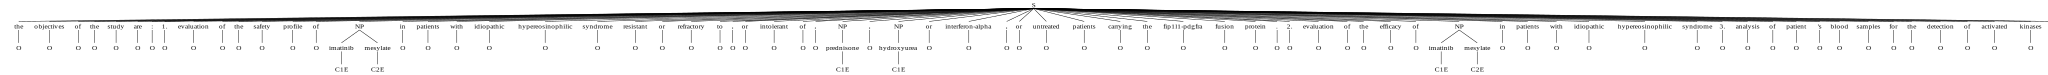

In [39]:
test_trees[26]

## Extract terms and map to preferred names

In [40]:
def extract_preferred_names_from_tree(tree, group_tag: str = 'NP') -> list[str]:
    terms = extract_grouped_terms(tree=tree, group_tag=group_tag)
    term_prefered_names = []
    for term_raw in terms:
        term = term_raw.lower()
        # print(term, term_raw)
        if term not in preferred_name_by_term:
            continue
        term_prefered_names.append(preferred_name_by_term[term])
    return list(set(term_prefered_names))    
    

In [41]:
extracted_terms = []
for tree in test_trees:
    extracted_terms.append(extract_preferred_names_from_tree(tree))
test_df = pd.DataFrame({
    'nct_id': summaries['nct_id'],
    'extracted_terms': extracted_terms
})

## Evaluate

In [42]:
test_df['gt_cleaned'] = test_df.nct_id.map(lambda x: ground_truth_cleaned[x])

In [43]:
test_df['match_count'] = test_df.apply(lambda row: len(set(row['extracted_terms']).intersection(set(row['gt_cleaned']))), axis=1)

In [44]:
test_df.head()

,nct_id,extracted_terms,gt_cleaned,match_count
0,NCT00037648,[anakinra],[anakinra],1
1,NCT00048542,"[adalimumab, methotrexate]","[adalimumab, methotrexate]",2
2,NCT00071487,[belimumab],[belimumab],1
3,NCT00071812,[belimumab],[belimumab],1
4,NCT00072839,[teduglutide],[teduglutide],1


In [45]:
test_df['extracted_terms_count'] = test_df['extracted_terms'].map(len)
test_df['gt_cleaned_count'] = test_df['gt_cleaned'].map(len)

In [46]:
true_positive_count = test_df['match_count'].sum()
precision = true_positive_count / test_df['extracted_terms_count'].sum()
recall = true_positive_count / test_df['gt_cleaned_count'].sum()
print(f'Precision: {precision: .2%}')
print(f'Recall: {recall: .2%}')


Precision:  100.00%
Recall:  98.25%


In [47]:
misses_df = test_df[(test_df['match_count'] != test_df['extracted_terms_count']) | (test_df['match_count'] != test_df['gt_cleaned_count'])]
misses_df

,nct_id,extracted_terms,gt_cleaned,match_count,extracted_terms_count,gt_cleaned_count
45,NCT00265122,[],[ustekinumab],0,0,1


### Check specific case(s)

In [48]:
_sum = summaries[summaries['nct_id']=='NCT00265122'].brief_summary.iloc[0]
print(_sum)

The purpose of this study is to examine the safety and efficacy of CNTO 1275 in participants with active Crohn's Disease.


In [49]:
index = summaries[summaries['nct_id']=='NCT00265122'].index[0]
index

45

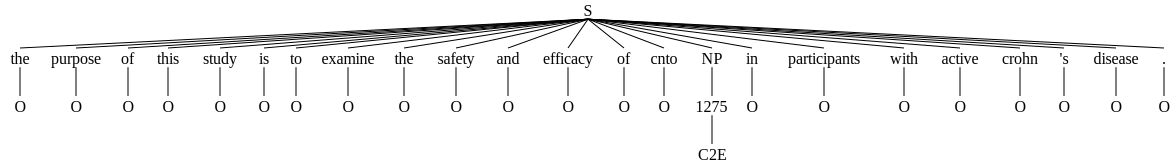

In [50]:
# This is a tagger issue, 'cnto' is tagged as other, it should have been tagged as 'C-2-E'
test_trees[index]

In [51]:
# terms_by_preferred_name = {}
# for _, row in synonyms_df.iterrows():
#     preferred_name = row['preferred_name']
#     synonyms = row['synonyms']
#     synonyms_cleaned = [synonym.replace(' ', '').lower() for synonym in synonyms]
#     terms_by_preferred_name[preferred_name] = synonyms_cleaned

In [52]:
# for term in terms_by_preferred_name['ustekinumab']:
#     if term in _sum:
#         print(term)

In [53]:
# terms_by_preferred_name['ustekinumab']

# Save

In [54]:
test_df.to_parquet(data_config['extraction_nltk_file_name'], index=False) 